# Evaluating Bot Performance (Chess)

In [34]:
import os
import matplotlib.pyplot as plt

parent = '/'.join(s for s in os.getcwd().split('/')[:-1])
print(parent)

/Users/benbellerose/Documents/GitHub/chappie.ai


In [35]:
import pandas as pd

ai = 'test_V2'

game_df = pd.read_csv(f'{parent}/skills/chess/data/models/{ai}/logs/game_log.csv')
game_df.head(5)

,state0,state1,state2,state3,state4,state5,state6,state7,state8,state9,...,prob4092,prob4093,prob4094,prob4095,action,value,reward,ELO,Game-ID,Date
0,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.00,0.0,4015.0,-1.0,0.0,NaN,03IH551KLDDYKVE,2022-01-20 17:34:58.782214
1,1.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.00,0.0,723.0,1.0,0.0,NaN,03IH551KLDDYKVE,2022-01-20 17:34:58.782214
2,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.08,0.0,4094.0,-1.0,0.0,NaN,03IH551KLDDYKVE,2022-01-20 17:34:58.782214
3,1.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.00,0.0,861.0,1.0,0.0,NaN,03IH551KLDDYKVE,2022-01-20 17:34:58.782214
4,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.00,0.0,4031.0,-1.0,0.0,NaN,03IH551KLDDYKVE,2022-01-20 17:34:58.782214


## Game Distrubution

In [36]:
results = []
for g, g_df in game_df.groupby('Game-ID'):
    results.append({'game':g, 'result':g_df.iloc[0]['value']})
results = pd.DataFrame(results)
print(f'Total Games Played = {len(results)}')
results['result'].value_counts(normalize=True).to_frame().T

Total Games Played = 212


,-1.0,1.0,0.0
result,0.462264,0.433962,0.103774


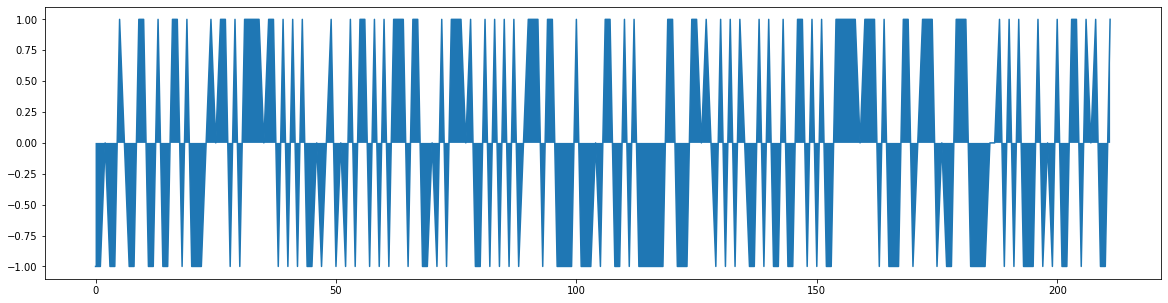

In [37]:
results.plot.line(figsize=(20, 5), legend=False)
plt.fill_between(results.index,results['result'])
plt.show()

## Game Play

In [22]:
import torch

y = 10

for batch, x in enumerate(range(0, len(game_df), y)):
    v_headers = ['value']
    r_headers = ['reward']
    a_headers = ['action']
    s_headers = [h for h in game_df if 'state' in h]
    p_headers = [h for h in game_df if 'prob' in h]
    
    s = game_df[s_headers].iloc[x:x+y]
    p = game_df[p_headers].iloc[x:x+y]
    v = game_df[v_headers].iloc[x:x+y]
    r = game_df[r_headers].iloc[x:x+y]
    a = game_df[a_headers].iloc[x:x+y] + 1
    
    a_0 = pd.DataFrame([{'action':0} for _ in range(len(a))])

    s_1 = game_df[s_headers].shift(periods = -1, axis = 0).iloc[x:x+y]
    if True in s_1.iloc[-1].isna().tolist():
        s_1.iloc[-1] = s.iloc[-1]
        s_1['state0'].iloc[-1] = 0 if s_1['state0'].iloc[-1] == 1 else 1
        
    p_1 = game_df[p_headers].shift(periods = -1, axis = 0).iloc[x:x+y]
    if True in p_1.iloc[-1].isna().tolist():
        p_1.iloc[-1] = p.iloc[-1]
        
    v_1 = game_df[v_headers].shift(periods = -1, axis = 0).iloc[x:x+y]
    if True in v_1.iloc[-1].isna().tolist():
        v_1.iloc[-1] = v.iloc[-1]
        
    r_1 = game_df[r_headers].shift(periods = -1, axis = 0).iloc[x:x+y]
    if True in r_1.iloc[-1].isna().tolist():
        r_1.iloc[-1] = r.iloc[-1]
    
    state = s.append(s, ignore_index = True)
    state = torch.tensor(state.values)
    #print('state\n', state, '\n')
    
    a_target = a_0.append(a, ignore_index = True)
    a_target = torch.tensor(a_target.values)
    #print('action\n', a_target, '\n')
    
    s_target = s.append(s_1, ignore_index = True)
    s_target = torch.tensor(s_target.values)
    #print('state target\n', s_target, '\n')
    
    p_target = p.append(p_1, ignore_index = True)
    p_target = torch.tensor(p_target.values)
    #print('policy target\n',p_target, '\n')
    
    v_target = v.append(v_1, ignore_index = True)
    v_target = torch.tensor(v_target.values)
    #print('value target\n', v_target, '\n')
    
    r_target = r.append(r_1, ignore_index = True)
    r_target = torch.tensor(r_target.values)
    #print('reward target\n', r_target, '\n')
    break

In [23]:
import numpy as np

board = np.zeros((64))
s_headers = [h for h in game_df if 'state' in h]
x_map = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] #Board x representation
y_map = ['8', '7', '6', '5', '4', '3', '2', '1'] #Board y representation

for x in range(len(game_df[s_headers]) - 1):
    c = game_df[s_headers].iloc[x]
    n = game_df[s_headers].iloc[x + 1]
    
    #Show current board
    for i in range(len(c)-1):
        board[i] = c.iloc[ i + 1]
    print(board.reshape((8,8)))
    
    #Show next board
    for i in range(len(n)-1):
        board[i] = n.iloc[ i + 1]
    print(board.reshape((8,8)))
    
    #Player action
    b_a = int(game_df['action'].iloc[x])
    a_map = np.zeros(4096)
    a_map[b_a] = 1
    a_map = a_map.reshape((8,8,8,8))
    a_index = [(cy, cx, ny, nx) for cy, cx, ny, nx in zip(*np.where(a_map == 1))][0]
    cur = f'{x_map[a_index[1]]}{y_map[a_index[0]]}'
    next = f'{x_map[a_index[3]]}{y_map[a_index[2]]}'
    print(cur, next)
    print('-----')
    break

[[12. 10. 11. 13. 14. 11. 10. 12.]
 [ 9.  9.  9.  9.  9.  9.  9.  9.]
 [ 2.  2.  2.  2.  2.  2.  2.  2.]
 [ 2.  2.  2.  2.  2.  2.  2.  2.]
 [ 2.  2.  2.  2.  2.  2.  2.  2.]
 [ 2.  2.  2.  2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.  3.  3.  3.]
 [ 6.  4.  5.  7.  8.  5.  4.  6.]]
[[12. 10. 11. 13. 14. 11. 10. 12.]
 [ 9.  9.  9.  9.  9.  9.  9.  9.]
 [ 2.  2.  2.  2.  2.  2.  2.  2.]
 [ 2.  2.  2.  2.  2.  2.  2.  2.]
 [ 2.  2.  2.  2.  2.  2.  2.  2.]
 [ 2.  2.  2.  2.  2.  2.  2.  4.]
 [ 3.  3.  3.  3.  3.  3.  3.  3.]
 [ 6.  4.  5.  7.  8.  5.  2.  6.]]
g1 h3
-----


In [7]:
p_headers = [h for h in game_df if 'prob' in h]

actions = []
for i, row in game_df[p_headers].iterrows():
    print(row[(row > 0)].to_dict())
    break
    actions.append({k.replace('prob',''):v for k, v in row[(row > 0)].to_dict().items()})

print(pd.DataFrame(actions))

{'prob3104': 0.06, 'prob3112': 0.04, 'prob3169': 0.04, 'prob3177': 0.04, 'prob3234': 0.04, 'prob3242': 0.04, 'prob3299': 0.04, 'prob3307': 0.08, 'prob3364': 0.04, 'prob3372': 0.04, 'prob3429': 0.08, 'prob3437': 0.04, 'prob3494': 0.04, 'prob3502': 0.06, 'prob3559': 0.08, 'prob3567': 0.04, 'prob3688': 0.04, 'prob3690': 0.04, 'prob4013': 0.04, 'prob4015': 0.08}
Empty DataFrame
Columns: []
Index: []


In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

G = nx.Graph()
for s in search.tree:
    for a in search.tree[s].n_s:
        G.add_edge(s,a)
        
pos = graphviz_layout(G, prog='dot')
#Display network graph -----------------------------
nx.draw(
    G, #Graph nodes & connections
    pos, #Position of graph
    with_labels=True #Labels on nodes
)
plt.rcParams['figure.figsize'] = [40, 40] #Resize graph
plt.show()

ModuleNotFoundError: No module named 'networkx'

## Training Results

In [38]:
training_df = pd.read_csv(f'{parent}/skills/chess/data/models/{ai}/logs/training_log.csv')
training_df.head(5)

,Date,Epoch,Samples,Time,hidden loss,backbone loss,Cca loss,value loss,policy loss,state loss,reward loss,model
0,2022-01-20 17:34:42.321151,0,76,2.109998,1.255555,2.378043,2.378043,1.081087,0.002288,1.150341,0.112727,skills/chess/data/models/test_V2
1,2022-01-20 17:34:44.017977,1,76,3.806534,1.064785,2.224819,2.224819,0.972654,0.002272,1.139409,0.045050,skills/chess/data/models/test_V2
2,2022-01-20 17:34:45.718220,2,76,5.506782,0.973472,2.156518,2.156518,0.926275,0.002253,1.154885,0.026851,skills/chess/data/models/test_V2
3,2022-01-20 17:34:47.391099,3,76,7.179655,0.941750,2.127108,2.127108,0.956423,0.002235,1.189350,0.024228,skills/chess/data/models/test_V2
4,2022-01-20 17:34:49.071026,4,76,8.859582,0.919223,2.085537,2.085537,0.924075,0.002218,1.169218,0.013881,skills/chess/data/models/test_V2


0       1.255555
1       1.160170
2       1.097937
3       1.058890
4       1.030957
          ...   
2115    0.901115
2116    0.893604
2117    0.887520
2118    0.881223
2119    0.878079
Name: hidden mavg, Length: 2120, dtype: float64


<AxesSubplot:>

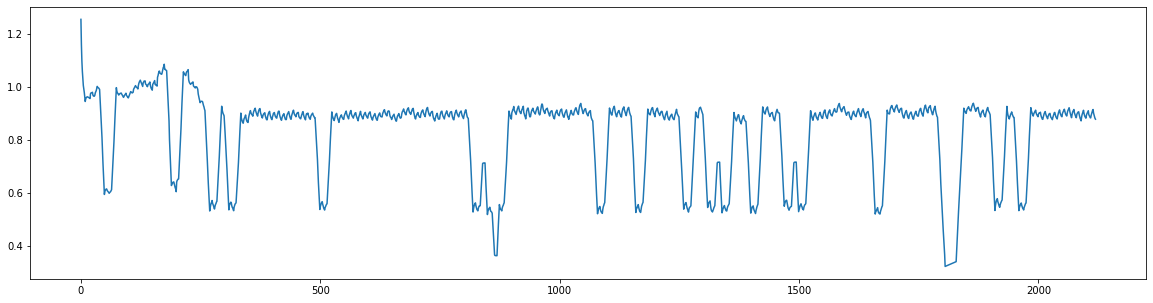

In [46]:
training_df['hidden mavg'] = training_df['hidden loss'].rolling(window=25, min_periods=1).mean()
print(training_df['hidden mavg'])
training_df[training_df['hidden mavg'] > training_df['hidden mavg'].quantile(0.01)]['hidden mavg'].plot.line(figsize=(20, 5), legend=False)

<AxesSubplot:>

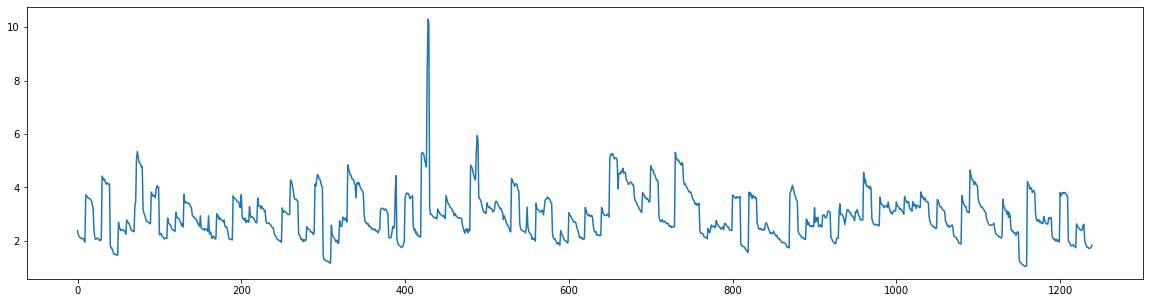

In [16]:
training_df['backbone loss'].plot.line(figsize=(20, 5), legend=False)

<AxesSubplot:>

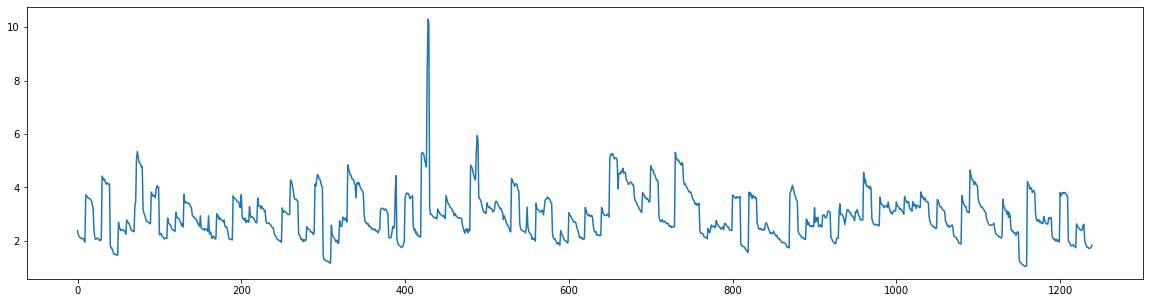

In [17]:
training_df['Cca loss'].plot.line(figsize=(20, 5), legend=False)

<AxesSubplot:>

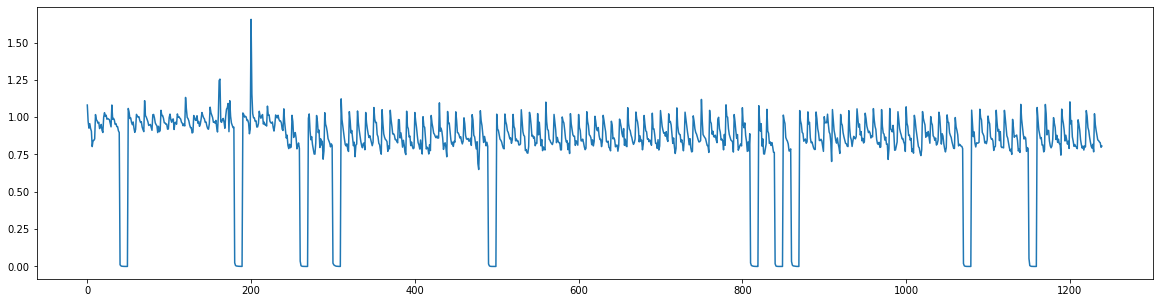

In [18]:
training_df['value loss'].plot.line(figsize=(20, 5), legend=False)

<AxesSubplot:>

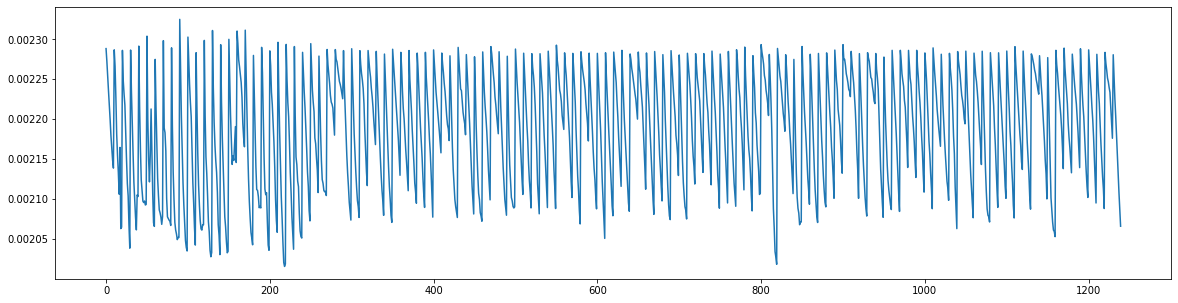

In [19]:
training_df['policy loss'].plot.line(figsize=(20, 5), legend=False)

<AxesSubplot:>

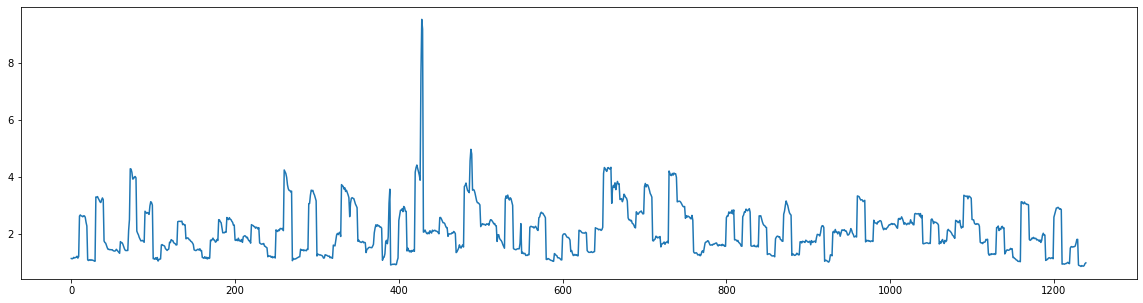

In [20]:
training_df['state loss'].plot.line(figsize=(20, 5), legend=False)

<AxesSubplot:>

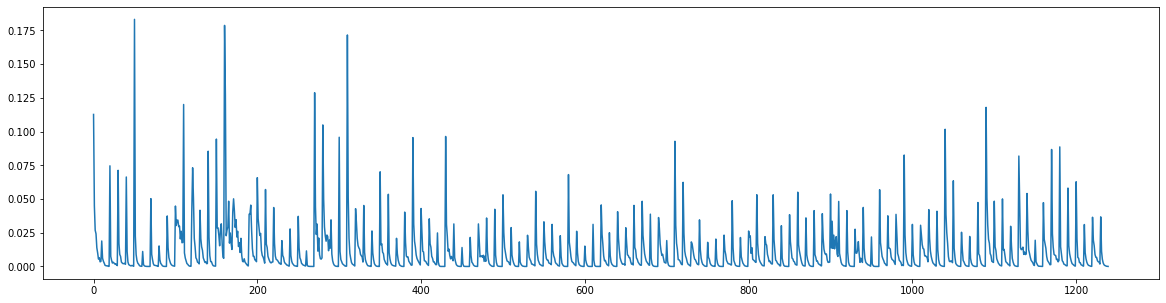

In [21]:
training_df['reward loss'].plot.line(figsize=(20, 5), legend=False)